# 東京エレクトロン株価（日足）

In [1]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

symbol = '8035.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-06-04 00:00:00+09:00,33858.071822,34214.368398,33610.643645,34105.500000,2918900,0.0,0.0
2024-06-05 00:00:00+09:00,33927.352261,34026.323534,33016.816553,33194.964844,3067500,0.0,0.0
2024-06-06 00:00:00+09:00,34639.945065,34887.373244,34145.088707,34343.031250,3512000,0.0,0.0
2024-06-07 00:00:00+09:00,34244.059779,34402.413813,33917.454585,34105.500000,1866100,0.0,0.0
2024-06-10 00:00:00+09:00,33996.630579,34432.104158,33877.865057,34422.207031,1740700,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-28 00:00:00+09:00,21900.000000,24540.000000,21855.000000,23740.000000,10056300,0.0,0.0
2024-11-29 00:00:00+09:00,23300.000000,23575.000000,23120.000000,23310.000000,4680200,0.0,0.0
2024-12-02 00:00:00+09:00,23415.000000,23900.000000,23345.000000,23640.000000,4230800,0.0,0.0


## パラボリック SAR

In [2]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 日足チャートとパラボリック SAR

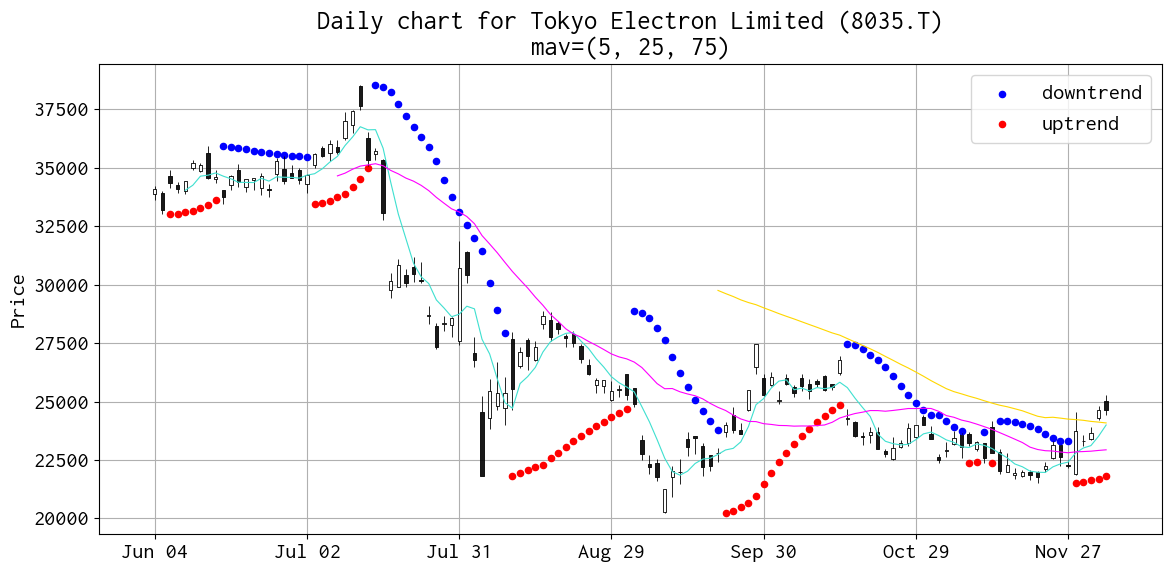

In [3]:
dict_psar = psar(df)

FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=20,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=20,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()

plt.tight_layout()
plt.savefig('daily_chart_8035.png')
plt.show()

In [4]:
df.tail(2)['Close']

Date
2024-12-03 00:00:00+09:00    24650.0
2024-12-04 00:00:00+09:00    24655.0
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2024-12-03 00:00:00+09:00    NaN
2024-12-04 00:00:00+09:00    5.0
Name: Close, dtype: float64

## 東京エレクトロン（後場）

In [6]:
df2 = ticker.history(period='1d', interval='1m')
dt_noon = pd.to_datetime('%s 12:00:00+09:00' % str(df2.index[0].date()))
print(dt_noon)
df2[df2.index > dt_noon]

2024-12-03 12:00:00+09:00


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-12-03 12:30:00+09:00,24630.0,24675.0,24625.0,24665.0,3556900,0.0,0.0
2024-12-03 12:31:00+09:00,24655.0,24725.0,24655.0,24680.0,67300,0.0,0.0
2024-12-03 12:32:00+09:00,24680.0,24715.0,24675.0,24705.0,14600,0.0,0.0
2024-12-03 12:33:00+09:00,24710.0,24730.0,24695.0,24705.0,29300,0.0,0.0
2024-12-03 12:34:00+09:00,24700.0,24715.0,24700.0,24705.0,7700,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-03 15:20:00+09:00,24615.0,24625.0,24605.0,24605.0,10600,0.0,0.0
2024-12-03 15:21:00+09:00,24610.0,24610.0,24600.0,24600.0,6400,0.0,0.0
2024-12-03 15:22:00+09:00,24605.0,24610.0,24600.0,24605.0,8700,0.0,0.0


# Tokyo Electron Limited (ADR)

In [7]:
symbol1 = 'TOELY'
ticker1 = yf.Ticker(symbol1)

df1 = ticker1.history(period='6mo')
df1

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-05-30 00:00:00-04:00,112.000000,112.000000,109.290001,109.599998,89200,0.0,0.0
2024-05-31 00:00:00-04:00,107.790001,108.070000,104.900002,106.160004,178900,0.0,0.0
2024-06-03 00:00:00-04:00,107.199997,109.919998,107.199997,109.300003,203100,0.0,0.0
2024-06-04 00:00:00-04:00,108.010002,110.919998,108.010002,110.400002,124300,0.0,0.0
2024-06-05 00:00:00-04:00,109.000000,111.610001,108.279999,111.610001,165700,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-22 00:00:00-05:00,71.110001,74.199997,71.110001,72.089996,146200,0.0,0.0
2024-11-25 00:00:00-05:00,73.000000,77.169998,73.000000,74.739998,185100,0.0,0.0
2024-11-26 00:00:00-05:00,74.089996,74.980003,72.470001,72.650002,148400,0.0,0.0


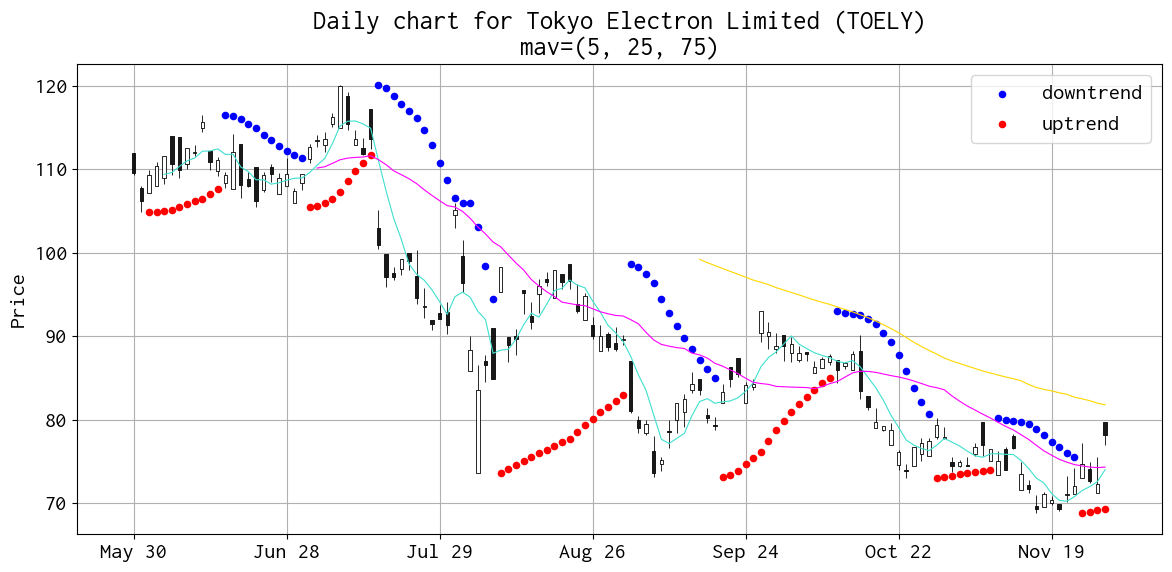

In [8]:
dict_psar = psar(df1)

FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=20,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=20,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df1,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker1.info['longName'], symbol1))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol1)

ax.grid()

plt.tight_layout()
plt.savefig('report_daily_chart_TOELY.png')
plt.show()